In [1]:
import os
import sys
sys.path.append('/home/kevinteng/Desktop/DE_Project')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from coord_conv import CoordConv
import cv2
import utils
import utils_vis
import utils_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

---------------------

# Retrieving and Preprocess Data

Image size:  100


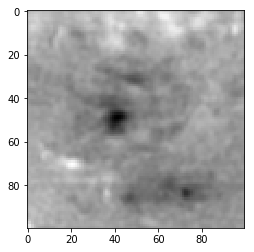

In [2]:
dataset = np.load('/home/kevinteng/Desktop/DeepLearning/Tensorflow2_0/test_npy/7-12-17-processed_dF.npy')

re_list = utils.resize(dataset, NEW_SIZE = 100)
IMG_SIZE = re_list.shape[1]

print('Image size: ', IMG_SIZE)
#Dimension for network should include the color channel 
re_list = np.expand_dims(re_list, axis = -1)
#Cast data type to float32 for TensorFlow
re_list = re_list.astype('float32')

for img in re_list:
    plt.imshow(np.reshape(img, (IMG_SIZE, IMG_SIZE)), cmap = 'gray')
    plt.show()
    
    break
    
#     if input()=='exit':
#         break

(100, 100, 1) float32


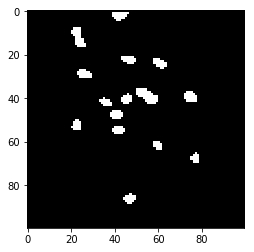

In [3]:
#retrieve and plot mean_ROI
mean_roi = np.load("/home/kevinteng/Desktop/mat/Ori_Lin/dg-13-7-12-17ROIs.mat_ROImask.npy")
mean_roi = cv2.resize(mean_roi, (100, 100))
#Dimension for network should include the color channel 
mean_roi = np.expand_dims(mean_roi, axis = -1)
#Cast data type to float32 for TensorFlow
mean_roi = mean_roi.astype('float32')

print(mean_roi.shape, mean_roi.dtype)
plt.imshow(np.squeeze(mean_roi), cmap = 'gray')

In [4]:
# centres = utils.retrieve_centroid(mean_roi, centroid_rad = 1)

# plt.imshow(np.squeeze(img_with_centroids), cmap = 'gray')
# plt.show()
# print('With centroids:')
# print(centres)

In [5]:
#calculate mean image

mean_img_ori = utils.mean_image(re_list, IMG_SIZE)
#apply min max norm for mean image
mean_img_ori = utils.min_max_norm(mean_img_ori)
mean_img_ori = np.expand_dims(mean_img_ori, -1)
print('Max value:', np.max(mean_img_ori))
print('Min value:', np.min(mean_img_ori))


Max value: 1.0
Min value: 0.0


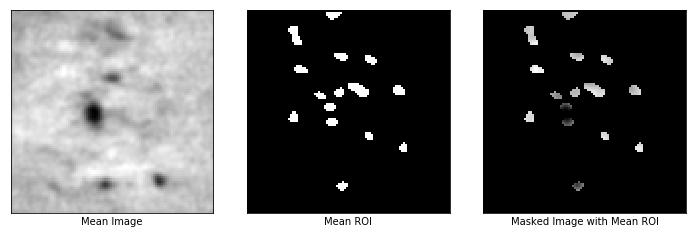

MSE:  0.590009163549358
Dice coefficient:  0.05908616320337883


In [6]:
from utils import masked_img, dice_coef_py, MSE_image
from utils_vis import plot_comparison

captions = ['Mean Image', 'Mean ROI', 'Masked Image with Mean ROI']
plot_comparison([mean_img_ori, mean_roi,masked_img(mean_img_ori, mean_roi)], 
                captions, n_col =3, figsize = (10, 10))
print('MSE: ', MSE_image(np.squeeze(mean_img_ori), mean_roi, IMG_SIZE))
#measure IOU with dice coeff
print('Dice coefficient: ',dice_coef_py(mean_roi, mean_img_ori))

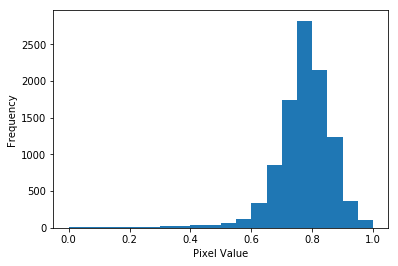

In [7]:
#plot historgram for mean image
plt.hist(mean_img_ori.ravel(),20,[0,1])
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

----------------------------------------------------------


# Model

In [8]:
#hyperparameters 
BATCH_SIZE = 16
MAX_STEP = 2000 #exceeding 5000 steps will crash!
REPEAT = 1000
lr = 0.001
data_augmentation = False

#Split data: 80% Training, 20% test
y_data = []
for i in range(len(re_list)):
    y_data.append(mean_roi)
    
y_data = np.asarray(y_data)
x_train, x_test, y_train, y_test = train_test_split(re_list, y_data, test_size = 0.2, random_state = 42)

#data generator
if data_augmentation:
    print('Augmented dataset!')
    BATCH_SIZE = 16 #system crash if batch size = 32 !
    ds_train = utils_model.data_aug(x_train, y_train, BATCH_SIZE)
else:
    ds_train = tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000).repeat(REPEAT).batch(BATCH_SIZE)

In [9]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.regularizers import l1
from utils_model import conv_block, coordconv_block

l1_coeff = 0.99
#filters_layer = [16, 32, 64, 32, 16]
filters_layer = [32, 64]

#build network
def Coord_conv(input_layer):
    coordconv_01 = coordconv_block(input_layer, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                      filters = filters_layer[0], kernel_size = 3, strides = 1, padding='same', 
                                       activation='relu', batch_norm = True)
    coordconv_02 = coordconv_block(coordconv_01, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                      filters = filters_layer[1], kernel_size = 3, strides = 1, padding='same', 
                                       activation='relu', kernel_regularizer = True, batch_norm = True,
                                   l1_coeff = l1_coeff)
    coordconv_03 = coordconv_block(coordconv_02, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                      filters = 1, kernel_size = 3, strides = 1, padding='same', 
                                       activation='sigmoid')
    return coordconv_03

def Convnet(input_layer):
    conv_01 = conv_block(input_layer, filters = filters_layer[0], kernel_size = 3, strides = 1, 
                             padding = 'same',  activation = 'relu',batch_norm = True) 
    conv_02 = conv_block(conv_01, filters = filters_layer[1], kernel_size = 3, strides = 1, 
                             padding = 'same',  activation = 'relu', kernel_regularizer = True,
                         batch_norm = True, l1_coeff = l1_coeff)
    conv_03 = conv_block(conv_02, filters = 1, kernel_size = 3, strides = 1, 
                             padding = 'same',  activation = 'sigmoid') 
    return conv_03
        
        

## Build Model

In [10]:
coordconv = True #toggle for coordconv and regular convnet
input_layer = Input(shape = (IMG_SIZE, IMG_SIZE, 1))

if coordconv:
    print('The model is in Coordconv')
    model = Model(input_layer, Coord_conv(input_layer))
else:
    print('The model is in regular Conv-net')
    model = Model(input_layer, Convnet(input_layer))

The model is in Coordconv
L1 regularizer is activate!


-----------------------------------------------------------------

In [11]:
# # ds_train = tf.data.Dataset.from_tensor_slices(re_list).repeat(1).batch(32)
# img_size = IMG_SIZE
# dst = tf.data.Dataset.from_tensor_slices(re_list).batch(32)

# stack_batch = tf.zeros((img_size,img_size))
# for i, img_batch in enumerate(dst):
#     stack = tf.zeros((img_size,img_size))
#     print(i)
#     #print(tf.cast(tf.shape(img_batch)[0], dtype = tf.dtypes.float32))
#     for images in img_batch:
#         images = tf.expand_dims(images, 0)
#         conv_img = model(images)
#         stack+=tf.squeeze(conv_img)
        
#     print('Batch size:', tf.cast(tf.shape(img_batch)[0], dtype = tf.dtypes.float32).numpy())
#     batch_mean = stack/(tf.cast(tf.shape(img_batch)[0], dtype = tf.dtypes.float32))
#     stack_batch += batch_mean

# mean_img=stack_batch/tf.cast(i+1, dtype = tf.dtypes.float32)
# mean_img=tf.reshape(mean_img, [img_size, img_size, 1])

In [12]:
# dst = tf.data.Dataset.from_tensor_slices(re_list).batch(32)
# sums = 0
# img_size = IMG_SIZE
# stack_batch = tf.zeros((img_size,img_size))
# for img in dst:
#     stack = tf.zeros((img_size,img_size))
#     #print(tf.shape(img))
#     for images in img:
#         stack+=tf.squeeze(images)
#     batch_mean = stack/(len(img))
#     stack_batch+=batch_mean
#     sums+=1
#     #print(sums)
# output = stack_batch/sums

In [13]:
# dst = tf.data.Dataset.from_tensor_slices(re_list).batch(32)
# sums = 0
# img_size = IMG_SIZE
# stack_batch = tf.zeros((img_size,img_size))
# for img in dst:
#     stack = tf.zeros((img_size,img_size))
#     #print(tf.shape(img))
#     conv_img = model(img)
#     for images in conv_img:
#         #sums+=1
#         stack+=tf.squeeze(images)
        
#     batch_mean = stack/(len(img))
#     stack_batch+=batch_mean
#     sums+=1
#     print(sums)
# output = stack_batch/sums

In [14]:
# sums= 0
# for imgs in conv_img:
#     sums+=1
    
# print(sums)

In [15]:
# stack = tf.zeros((img_size,img_size))
# for imgs in re_list:
#     stack+=np.squeeze(imgs)
    
# output = stack/len(re_list)

## Train Model

In [16]:
from utils_model import img_mean, min_max_norm
#loss function
loss_fn = tf.losses.MeanSquaredError()
#loss_fn = lambda x,y: dice_coef_loss(x,y)
#loss_fn = lambda x,y: jaccard_distance_loss(x,y)

#annealer = lambda x: lr * 0.8 ** x
#optimizer 
opt = tf.optimizers.Adam(lr)

@tf.function
def train(imgs, mean_roi, img_size):
    with tf.GradientTape() as tape:
        stack=tf.zeros((img_size,img_size))
        for images in imgs:
            images = tf.expand_dims(images, 0)
            conv_img = model(images)
            stack+=tf.squeeze(conv_img)
         
        mean_img=stack/(tf.shape(imgs,out_type=tf.dtypes.float32)[0])
        mean_img=tf.reshape(mean_img, [img_size, img_size, 1])
        xent = loss_fn(mean_roi, mean_img)

    grads = tape.gradient(xent, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    
    return xent, mean_img, grads

# @tf.function
# def train(batched_imgs, mean_roi, img_size):
#     with tf.GradientTape() as tape:
#         stack_batch = tf.zeros((img_size,img_size))
#         sums = 0
        
#         #loop for batches 
#         for img_batch in batched_imgs:
#             stack = tf.zeros((img_size,img_size))
#             print("outer loop")
#             #loop for images inside the batch
#             for images in img_batch:
#                 print("inner loop")
#                 images = tf.expand_dims(images, 0)
#                 conv_img = model(images)
#                 #sum of all pixel values in the batch
#                 stack+=tf.squeeze(conv_img)
            
#             batch_mean = stack/(tf.cast(tf.shape(img_batch)[0], dtype = tf.dtypes.float32))
#             stack_batch += batch_mean
#             sums+=1
        
#         #sums = int(len(batched_imgs)/batch)
#         mean_img=stack_batch/tf.cast(sums, dtype = tf.dtypes.float32)
#         mean_img=tf.reshape(mean_img, [img_size, img_size, 1])
#         xent = loss_fn(mean_roi, mean_img)

#     grads = tape.gradient(xent, model.trainable_variables)
#     opt.apply_gradients(zip(grads, model.trainable_variables))
    
#     return xent, mean_img

# @tf.function
# def train(batched_imgs, mean_roi, img_size):
#     with tf.GradientTape() as tape:
#         stack_batch = tf.zeros((img_size,img_size))
#         sums = 0
        
#         #loop for batches 
#         for img_batch in batched_imgs:
#             stack = tf.zeros((img_size,img_size))
            
#             #feed the network with batches 
#             conv_img = model(img_batch)
#             #print("outer loop")
#             #loop for images inside the batch
#             for images in conv_img:
#                 #print("inner loop")
#                 #sum of all pixel values in the batch
#                 stack+=tf.squeeze(images)
            
#             batch_mean = stack/(tf.cast(tf.shape(img_batch)[0], dtype = tf.dtypes.float32))
#             stack_batch += batch_mean
#             sums+=1
        
#         #sums = int(len(batched_imgs)/batch)
#         mean_img=stack_batch/tf.cast(sums, dtype = tf.dtypes.float32)
#         #ensure that the size of the images match during loss calculationta
#         mean_img=tf.reshape(mean_img, [img_size, img_size, 1])
#         xent = loss_fn(mean_roi, mean_img)

#     grads = tape.gradient(xent, model.trainable_variables)
#     opt.apply_gradients(zip(grads, model.trainable_variables))
    
#     return xent, mean_img, grads

ori_list = [] #original image list
de_list = [] #mean image fromt the network list
loss_list = [] #loss list

img_batch = re_list
epochs = 0

dst = tf.data.Dataset.from_tensor_slices(re_list).batch(32)

while epochs < 10:
    #print('Epochs!:', epochs+1)
    
    xent, mean_img, grads =train(re_list, mean_roi, IMG_SIZE)
    de_list.append(mean_img)
    loss_list.append(xent)

    print("Epochs {:2d}, Loss: {}".format(epochs, xent.numpy()))
    print("Gradient min:{}, max:{}".format(np.min(grads[0]), np.max(grads[0])))
    print()
    epochs+=1

Epochs  0, Loss: 0.6822565197944641
Gradient min:-2.5144104957580566, max:2.0610604286193848

Epochs  1, Loss: 0.03284914419054985
Gradient min:-0.0011629433138296008, max:0.0029908702708780766

Epochs  2, Loss: 0.033316195011138916
Gradient min:-0.00023681165475863963, max:0.0007267819019034505

Epochs  3, Loss: 0.03342219814658165
Gradient min:-9.145477815764025e-05, max:0.0002895040961448103

Epochs  4, Loss: 0.033457886427640915
Gradient min:-5.05004427395761e-05, max:0.00015451872604899108

Epochs  5, Loss: 0.03347371146082878
Gradient min:-3.189030758221634e-05, max:9.600677731214091e-05

Epochs  6, Loss: 0.03348197042942047
Gradient min:-2.2392063328879885e-05, max:6.542828486999497e-05

Epochs  7, Loss: 0.03348677605390549
Gradient min:-1.6697636965545826e-05, max:4.781394454766996e-05

Epochs  8, Loss: 0.033489808440208435
Gradient min:-1.3015899639867712e-05, max:3.667340206447989e-05

Epochs  9, Loss: 0.0334918349981308
Gradient min:-1.0623658454278484e-05, max:2.92053500743

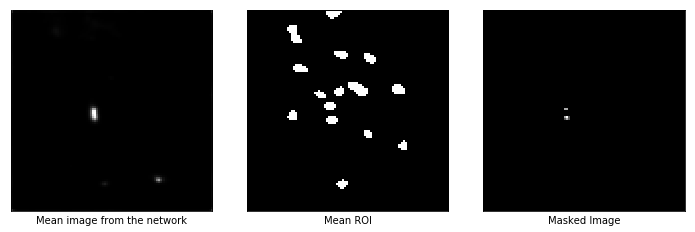

Loss: 0.03347371
Dice coefficient:  0.0007919473595365213



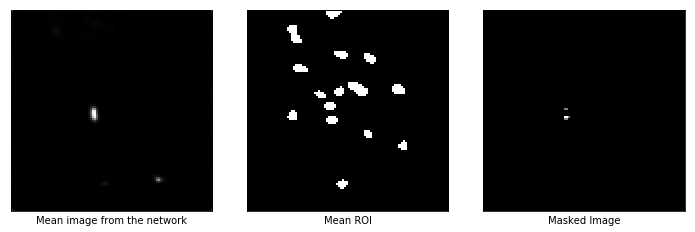

Loss: 0.03348197
Dice coefficient:  0.0005419984976052256



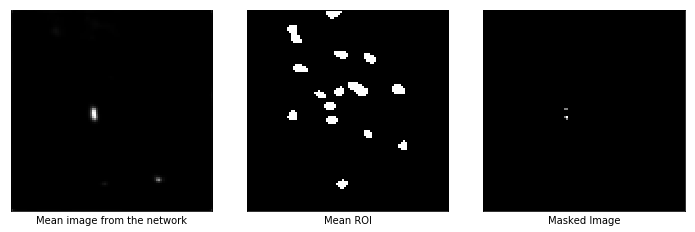

Loss: 0.033486776
Dice coefficient:  0.00039692054151323696



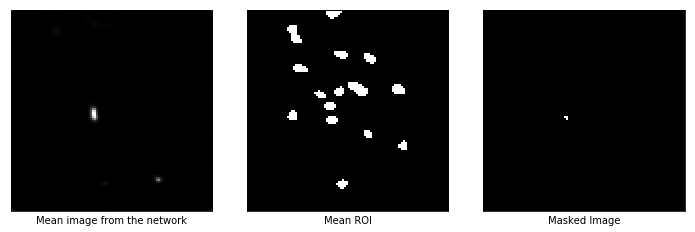

Loss: 0.03348981
Dice coefficient:  0.00030563985427323615



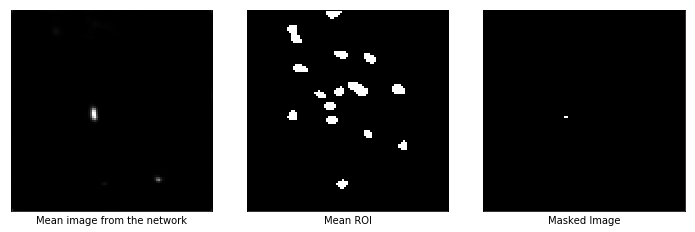

Loss: 0.033491835
Dice coefficient:  0.00024464965370311534


In [17]:
#plot for mean image of last 10 steps w.r.t mean roi 
last_n_steps = 5
for i in range(last_n_steps):
    mean_image = de_list[len(de_list) - last_n_steps + i]
    mean_image = np.asarray(mean_image) #cast tf object into np array
    masked_image = masked_img(mean_image, mean_roi)
    
    #plot
    inp_imgs = [mean_image , mean_roi, masked_image]
    captions = ['Mean image from the network',
               'Mean ROI', 
               'Masked Image']
    plot_comparison(inp_imgs, captions,n_col = 3, figsize = (10,10))
    
    print('Loss:', loss_list[len(de_list) - last_n_steps + i].numpy())
    print('Dice coefficient: ', dice_coef_py(mean_roi, mean_image))

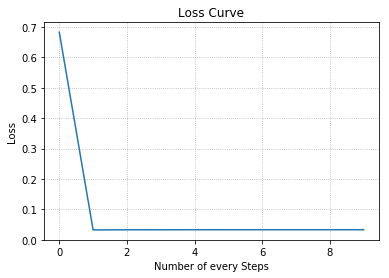

In [18]:
utils_vis.plot_loss(loss_list)

-------------------------------------------------

# Predict

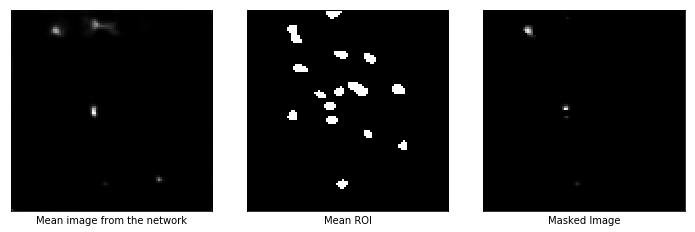

MSE for predicted image:  0.03256109924316406
Dice coefficient:  0.05980207599883257



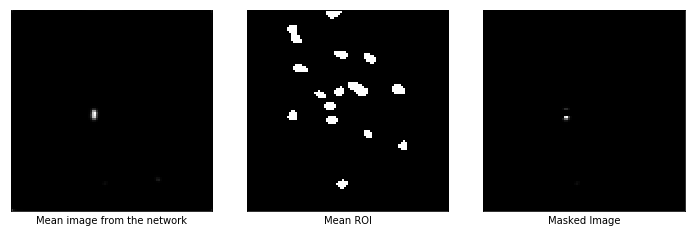

MSE for predicted image:  0.0334529052734375
Dice coefficient:  0.019812136271616543



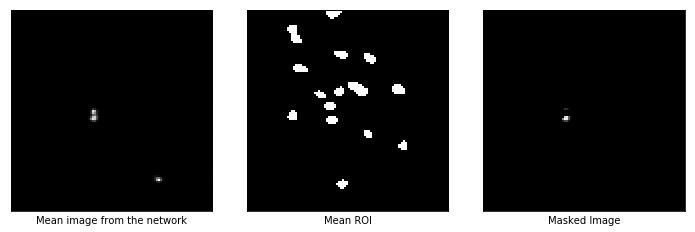

MSE for predicted image:  0.03320260009765625
Dice coefficient:  0.031842136325844025



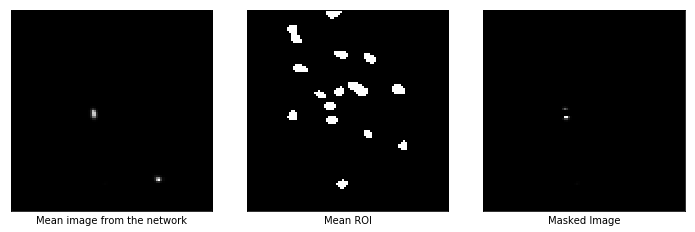

MSE for predicted image:  0.0337391845703125
Dice coefficient:  0.010867883445596194



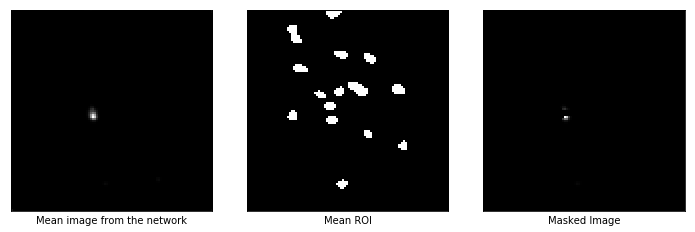

MSE for predicted image:  0.03313591918945313
Dice coefficient:  0.024325020109640858


In [19]:
sums = 0
slices = 20 #slices of image from image stack 
n = 5

#create data generator for test set
ds_test = tf.data.Dataset.from_tensor_slices(x_test).shuffle(10000).repeat(REPEAT).batch(slices)

for i, (test_batch) in enumerate(ds_test):
    assert test_batch.shape[0] == slices

    conv_img = model(test_batch)
    mean_img = img_mean(conv_img, IMG_SIZE)
    mean_img = min_max_norm(mean_img)

    mean_image = np.asarray(mean_img) #cast tf object into np array
    masked_image = masked_img(mean_image, mean_roi)
    inp_imgs = [np.squeeze(mean_img), mean_roi, masked_image]

    captions = ['Mean image from the network',
               'Mean ROI', 
               'Masked Image']
    plot_comparison(inp_imgs, captions, n_col = 3,figsize = (10,10))

    print('MSE for predicted image: ', MSE_image(mean_img, mean_roi, IMG_SIZE))
    print('Dice coefficient: ', dice_coef_py(mean_roi, mean_image))
    
    sums+=1
    
    #plot only n images for prediction
    if sums == n:
        break

-----------------------------------------------

# Visualizing Feature Maps

In [20]:
from utils_vis import layers_dict, feature_maps, plot_feature_maps, layers_name

layer_dict = layers_dict(model)
layer_name = layers_name(model)

input_1
coord_conv
batch_normalization
activation
coord_conv_1
batch_normalization_1
activation_1
coord_conv_2
activation_2


In [21]:
if coordconv:
    layer_name = 'coord_conv'
else:
    layer_name = 'conv2d'
    
layer_output = layer_dict[layer_name].output

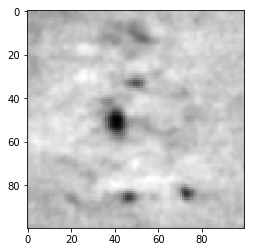

In [22]:
# taking the mean over all stacks as input
test_img = np.asarray(tf.expand_dims(mean_img_ori, 0)) #(1, img size, img size, 1)
#test_img = tf.expand_dims(test_img, -1) #(1, img size, img size, 1)
plt.imshow(np.squeeze(test_img), cmap = 'gray')
plt.show()

## Visualizing Last Layer of Feature Maps

Shape of feature maps: (1, 100, 100, 64)
Number of feature maps in layer:  64


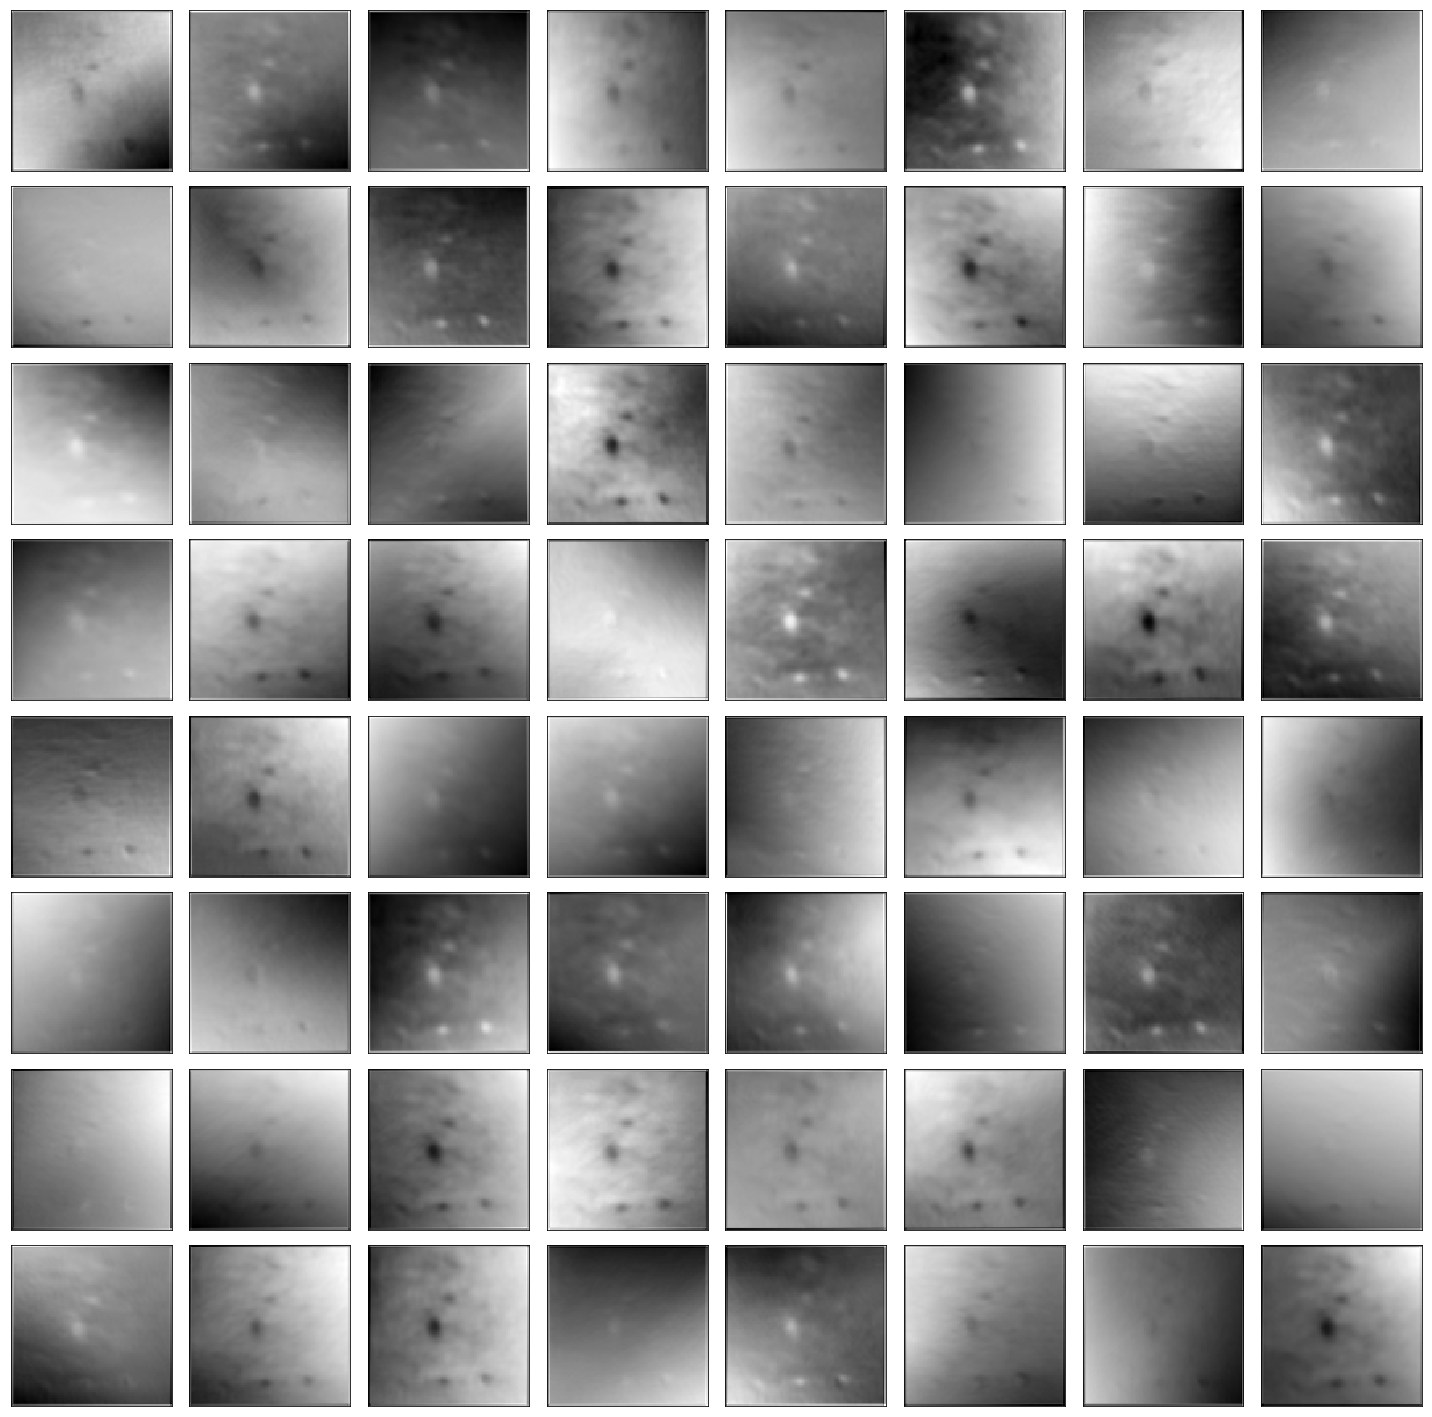

In [23]:
test_map = feature_maps(model, '{}_1'.format(layer_name), test_img)
plot_feature_maps(test_map, 8, 8, figsize = (20,20))

## Visualizing First Layer of Feature Maps

Shape of feature maps: (1, 100, 100, 32)
Number of feature maps in layer:  32


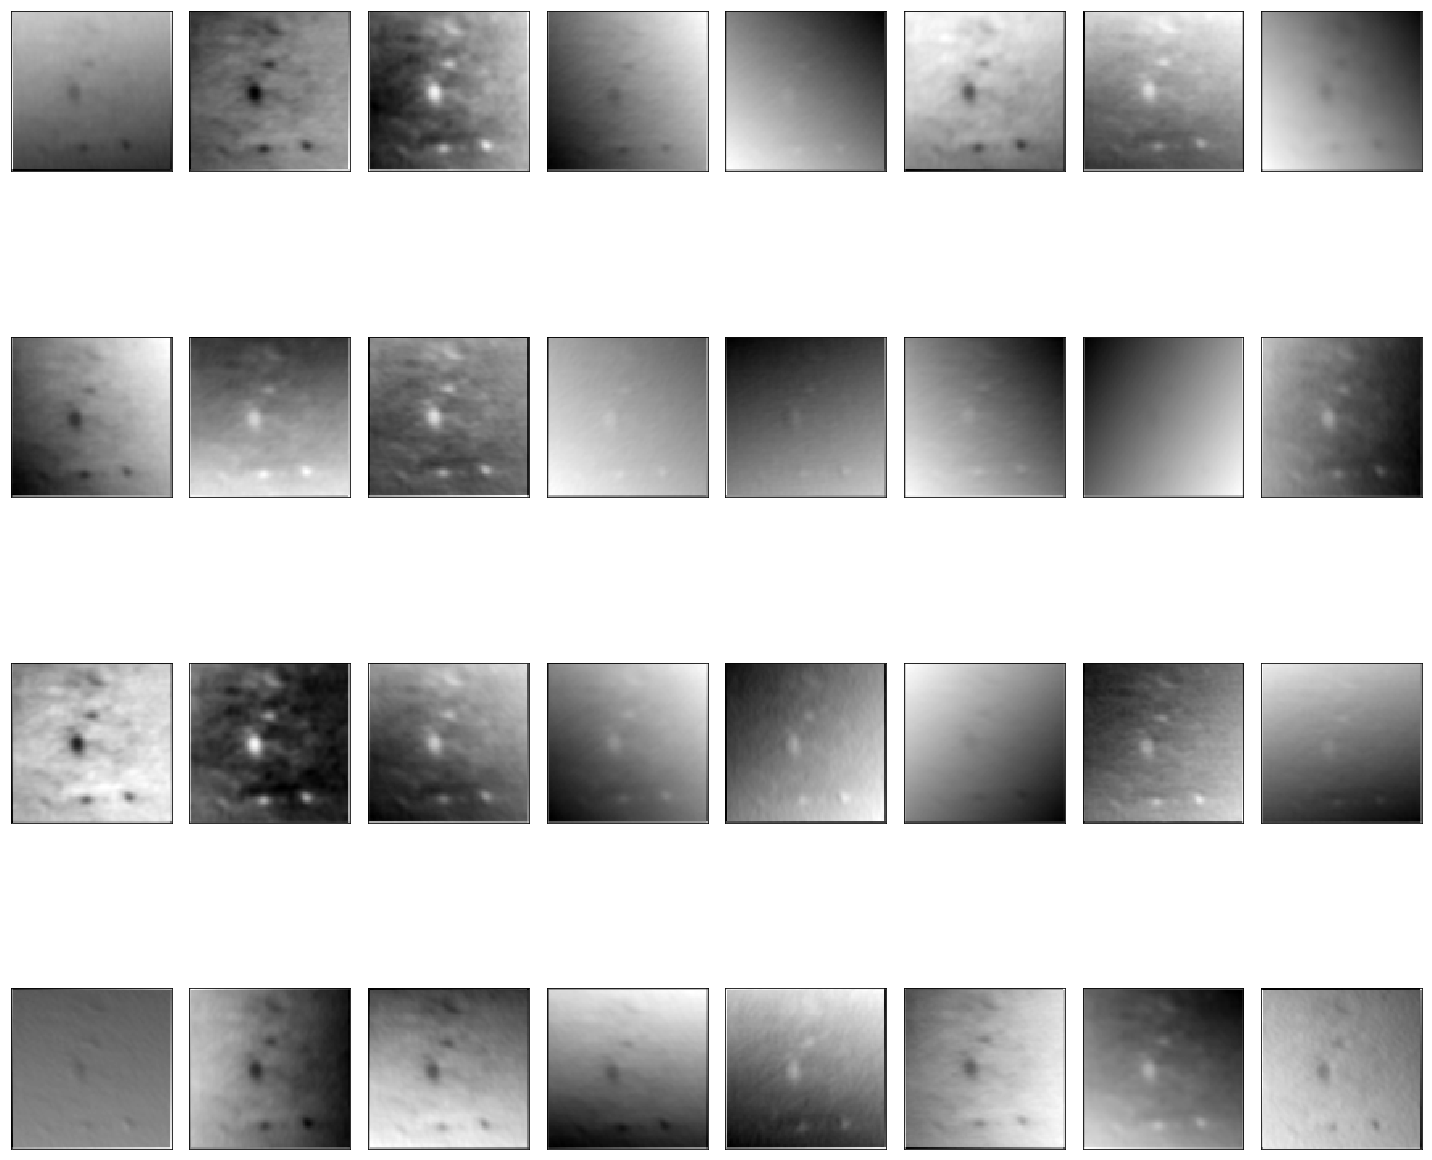

In [24]:
test_map02 = feature_maps(model, '{}'.format(layer_name), test_img)
plot_feature_maps(test_map02, 4, 8, figsize = (20,20))

--------------------------------

# Appendix

In [25]:
#model.summary()